# **Sentiment Analysis on Twitter Data using LSTM**

In [32]:
%%capture
!pip install kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [29]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import re,os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
import nltk

## Extracting Kaggle dataset for training the model

In [2]:
#path='/content/drive/MyDrive/BigDataProcessing/Project/Kaggle_train_dataset/'
df = pd.read_csv('tweet_sentiment.csv')   # training dataset file got from kaggle 
print(df)

# set the vocabulary size
vocabSize = 5000

# create a tokenizer object
tokenizer = Tokenizer(num_words = vocabSize, split=' ')
clean_tweets = df['cleaned_tweets'].astype(str) # specifying the field datatype

# apply tokenizing method on clean tweets to convert it into vector form
tokenizer.fit_on_texts(clean_tweets.values)
X_train = tokenizer.texts_to_sequences(clean_tweets)

# add some padding elements in vector to make the equal size vector for every tweets
X_train = pad_sequences(X_train, maxlen = 60, padding = 'pre', truncating = 'pre') 

# encoding labels
le = LabelEncoder()
y_train = le.fit_transform(df['sentiment'])
y_train = y_train.reshape(-1, 1)

# one hot encoding on labels
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train)
y_train = enc.transform(y_train).toarray()
print(y_train)
# print("X_train\n")
# print(X_train)
# print(X_train.shape, y_train.shape)

                                          cleaned_tweets  sentiment
0      video offic mind busi david solomon tell gs in...          0
1      price lumber lb f sinc hit ytd high maci turna...          0
2                                say american dream dead         -1
3      barri silbert extrem optimist bitcoin predict ...          1
4      satellit avoid attack space junk circl earth paid         -1
...                                                  ...        ...
28435                                    fb c f f cb ecf          0
28436                                                btc          0
28437  rt hd nuff said tel telcoin telfam crypto bloc...          0
28438                                                btc          0
28439   stellar xlm price binanc registr open limit time          0

[28440 rows x 2 columns]
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


## LSTM Model building and training 

In [3]:
# LSTM model
lstm_out = 128

model = Sequential()
model.add(Embedding(input_dim = vocabSize, output_dim=16, input_length = 60))  # add one embedding layer
model.add(SpatialDropout1D(0.4))  # add one spatial drop out layer
model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))  # add LSTM layer
model.add(Dense(3, activation = 'softmax'))  # add dense layer with 3 output neurons because we consider 3 sentiments
print(model.summary())
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#  training the model
batchSize = 64
print(X_train.shape, y_train.shape)

model_history=model.fit(X_train, y_train, epochs = 10,batch_size = batchSize, verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 16)            80000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 16)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 154,627
Trainable params: 154,627
Non-trainable params: 0
_________________________________________________________________
None
(28440, 60) (28440, 3)
Epoch 1/10
445/445 [==============================] - 83s 179ms/step - loss: 0.5382 - accuracy: 0.7901
Epoch 2/10
445/445 [==============================] - 79s 177ms/step - loss: 0.2066 - accuracy: 0.9369
Epoch 3/10
445

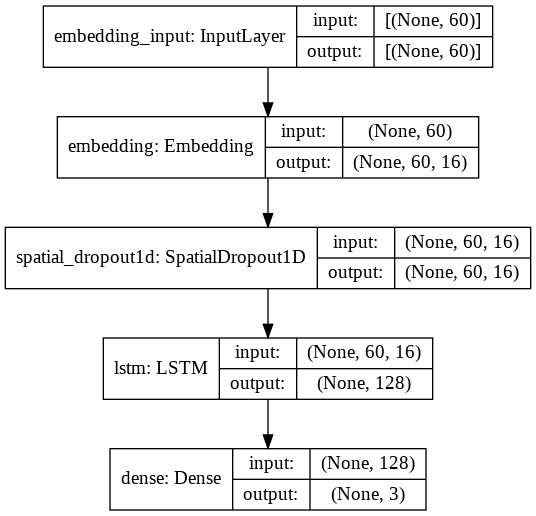

In [5]:
# pictorial representation of LSTM model

from keras.utils.vis_utils import plot_model
#path2='/content/drive/MyDrive/BigDataProcessing/Project/'
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_history.history.keys()

dict_keys(['loss', 'accuracy'])

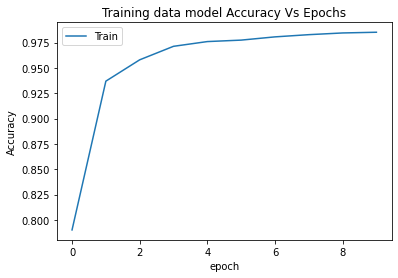

In [6]:
# plot the LSTM model accuracy graph after every epoch 

import keras
from matplotlib import pyplot as plt

plt.plot(model_history.history['accuracy'])
plt.title('Training data model Accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

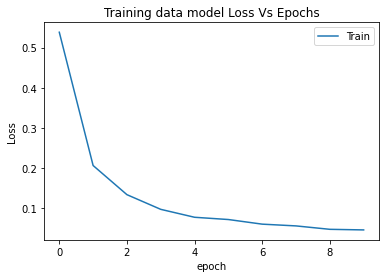

In [7]:
# plot the LSTM model loss graph after every epoch 

plt.plot(model_history.history['loss'])
plt.title('Training data model Loss Vs Epochs')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
list(le.inverse_transform([0,1,2]))

[-1, 0, 1]

## Uploading the cleaned and preprocessed streaming tweets  of stock data extracted from twitter API.

In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving new_clean_tweets.csv to new_clean_tweets.csv
User uploaded file "new_clean_tweets.csv" with length 658919 bytes


In [10]:
# Read the real time tweets after doing preprocessing

df1 = pd.read_csv('new_clean_tweets.csv')
print(df1.head())

twt = df1['Clean_text']
twt = tokenizer.texts_to_sequences(twt)  # make vector for every tweets
# print(twt)

# padding the extracted streaming tweets to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=60, dtype='int32', value=0)  # padding some elements into vector if vector has smaller length

tweetSentiment = model.predict(twt,batch_size=1,verbose = 2)

                        TimeStamp  ...                                         Clean_text
0  Thu Apr 15 05:02:35 +0000 2021  ...  think would like hire chap definitely accounta...
1  Thu Apr 15 05:02:52 +0000 2021  ...  tatamotors look short candidate unless take lv...
2  Thu Apr 15 05:02:54 +0000 2021  ...  india nplease find feedback serious dissatisfa...
3  Thu Apr 15 05:02:57 +0000 2021  ...  best wish tata group company employee amp fami...
4  Thu Apr 15 05:03:04 +0000 2021  ...  cars just need better petrol engine new turbo ...

[5 rows x 3 columns]
4701/4701 - 37s


In [11]:
#checking the value of maxindex among the three in prediction output
#vector by the LSTM model built
for sentiment in tweetSentiment[:10]:
  maxIndex = np.argmax(sentiment)
  print(maxIndex)

2
1
2
2
2
1
2
1
1
1


In [13]:
#Sentiment label will be assigned based on maximum index value

predictedLabels = []
for sentiment in tweetSentiment:
  #print(sentiment)
  
  maxIndex = np.argmax(sentiment)
  if(maxIndex == 0):
    predictedLabels.append('negative')
  elif(maxIndex == 1):
    predictedLabels.append('neutral')
  else:
    predictedLabels.append('positive')
  # maxValue = 0

df1['predicted_sentiment'] = pd.Series(predictedLabels)
print("Predicted Sentiment:\n", predictedLabels[:20])

Predicted Sentiment:
 ['positive', 'neutral', 'positive', 'positive', 'positive', 'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'neutral', 'negative', 'neutral', 'negative']


For the evaluation of results obtained from the LSTM model using standard anlysis tool Vader to label the testing data in order to estimate the model performance

In [14]:
# use VADER to get the ground truth sentiment of tweet
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

nltk.download('vader_lexicon')

# create object of SentimentIntensityAnalyzer class
sid = SentimentIntensityAnalyzer()

# return polarity score of tweet
def getCompoundScore(text):
    return sid.polarity_scores(text)

# return only compound score of tweet
def getCompoundValue(score):
    return score['compound']
    
# classify the tweet in 3 sentiment based on it's compound score
def classifyScore(score):
    if(score > 0):
        return "positive"
    elif(score < 0):
        return "negative"
    else:
        return "neutral"

df1['Score'] = df1['Clean_text'].apply(getCompoundScore)
df1['Compound'] = df1['Score'].apply(getCompoundValue)
df1['Label'] = df1['Compound'].apply(classifyScore)
df1.drop(columns=['Score', 'Compound'])
df1.to_csv('test_labels_tweets.csv')  # write ground truth sentiment value in file
# print(df.groupby('Label').count())

print(df1.head(5))

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
                        TimeStamp  ...     Label
0  Thu Apr 15 05:02:35 +0000 2021  ...  positive
1  Thu Apr 15 05:02:52 +0000 2021  ...   neutral
2  Thu Apr 15 05:02:54 +0000 2021  ...  negative
3  Thu Apr 15 05:02:57 +0000 2021  ...  positive
4  Thu Apr 15 05:03:04 +0000 2021  ...  positive

[5 rows x 7 columns]


In [15]:
# use labelEncoder to encode the ground truth sentiment 
le = LabelEncoder()
actualLabel = le.fit_transform(df1['Label']) #label assigned using Vader tool on testing data
actualLabel = actualLabel.reshape(-1, 1)


predictedLabel = le.transform(df1['predicted_sentiment'])#label predicted by LSTM model on testing data
predictedLabel = predictedLabel.reshape(-1, 1)

In [16]:
k=le.inverse_transform([0,1,2])
k=[x.upper() for x in k]
k

['NEGATIVE', 'NEUTRAL', 'POSITIVE']

## **Finding accuracy**

Accuracy : 63.6248 % 

Classification report : 
               precision    recall  f1-score   support

           0       0.81      0.36      0.50      1202
           1       0.44      0.95      0.60      1154
           2       0.87      0.62      0.72      2345

    accuracy                           0.64      4701
   macro avg       0.71      0.65      0.61      4701
weighted avg       0.75      0.64      0.64      4701
 



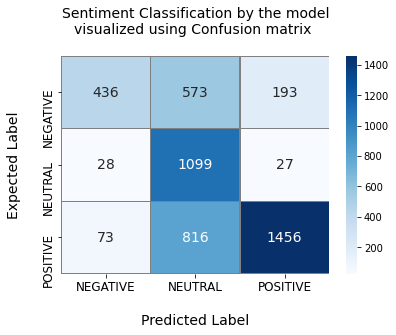

In [ ]:
# Find the accuracy of LSTM model by comparing predicted and ground truth sentiment

from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

ax_ticks=[0.5,1.5,2.5]
print("Accuracy :",np.round(accuracy_score(actualLabel,predictedLabel) * 100,4), "% \n")
print("Classification report : \n",classification_report(actualLabel,predictedLabel), "\n")

# plot confusion matrix
ccmat=confusion_matrix(actualLabel, predictedLabel)
sns.heatmap(ccmat,annot=True,fmt=".4g", cmap='Blues',linewidths=0.1,
            annot_kws={"fontsize":14},linecolor='gray')
plt.title("Sentiment Classification by the model\nvisualized using Confusion matrix \n",fontsize= 14)
plt.xlabel('\nPredicted Label',fontsize= 14)
plt.ylabel('Expected Label\n',fontsize= 14)
plt.xticks(ax_ticks, labels=k ,fontsize= 12)
plt.yticks(ax_ticks, labels=k,fontsize= 12)

plt.show()

In [ ]:
results=pd.DataFrame(ccmat)
correct_pred=[]
for i in range(0,results.shape[0]):
  correct_pred.append(results[i][i])

import seaborn as sns
import plotly.express as px 
import pandas as pd 
import matplotlib.pyplot as plt

## **Visualization of tweets**

In [17]:
from datetime import datetime  
from datetime import date 

#converting the time stamp to datetime object and extracting date part from it

df1['date'] = pd.to_datetime(df1['TimeStamp'])
df1['date'] =(df1['date'].dt.date).astype(str)
df1['predictedLabel'] = predictedLabel

In [18]:
df1.head()

,TimeStamp,Company,Clean_text,predicted_sentiment,Score,Compound,Label,date,predictedLabel
0,Thu Apr 15 05:02:35 +0000 2021,Mahindra & Mahindra Limited,think would like hire chap definitely accounta...,positive,"{'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'comp...",0.7964,positive,2021-04-15,2
1,Thu Apr 15 05:02:52 +0000 2021,Tata Motors Limited,tatamotors look short candidate unless take lv...,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,2021-04-15,1
2,Thu Apr 15 05:02:54 +0000 2021,Tata Motors Limited,india nplease find feedback serious dissatisfa...,positive,"{'neg': 0.254, 'neu': 0.565, 'pos': 0.181, 'co...",-0.0772,negative,2021-04-15,2
3,Thu Apr 15 05:02:57 +0000 2021,Tata Motors Limited,best wish tata group company employee amp fami...,positive,"{'neg': 0.0, 'neu': 0.566, 'pos': 0.434, 'comp...",0.7845,positive,2021-04-15,2
4,Thu Apr 15 05:03:04 +0000 2021,Tata Motors Limited,cars just need better petrol engine new turbo ...,positive,"{'neg': 0.0, 'neu': 0.619, 'pos': 0.381, 'comp...",0.8979,positive,2021-04-15,2


In [19]:
# group by the tweets according to date
v = df1[['Clean_text','date']].groupby(['date']).count().reset_index()
v=v.sort_values(by='date')
v['date']=v['date'].astype(str)
v.head()

,date,Clean_text
0,2021-04-15,725
1,2021-04-16,593
2,2021-04-20,757
3,2021-04-22,1447
4,2021-04-23,1179


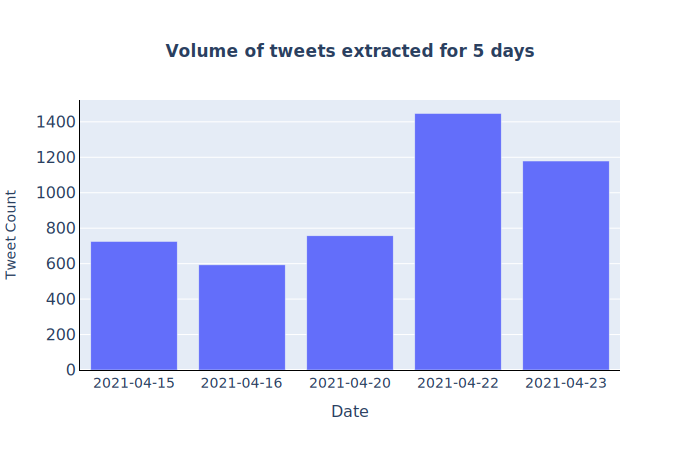

In [33]:
# plot the bar graph of number of tweets per day

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar( y=list(v['Clean_text']), x=v['date'].unique())
])
# Change the bar mode
fig.update_layout(title={
        'text': '<b>Volume of tweets extracted for 5 days</b>',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
         barmode='group',
        yaxis_tickfont_size=16,
        xaxis=dict(
            type='category',
            title='Date',
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(
            x=1.0,
            y=1.0,),
        legend_font_size=14
    )
fig.update_xaxes(showline=True, linewidth=1, linecolor='black',
                 )
fig.update_yaxes(title='Tweet Count',showline=True, linewidth=1, linecolor='black')
fig.show()

In [35]:
#grouping count of tweets based on sentiment and date and plot the graph
plot2_dt = df1[['Clean_text','date','predicted_sentiment']].groupby(['predicted_sentiment','date']).count().reset_index()

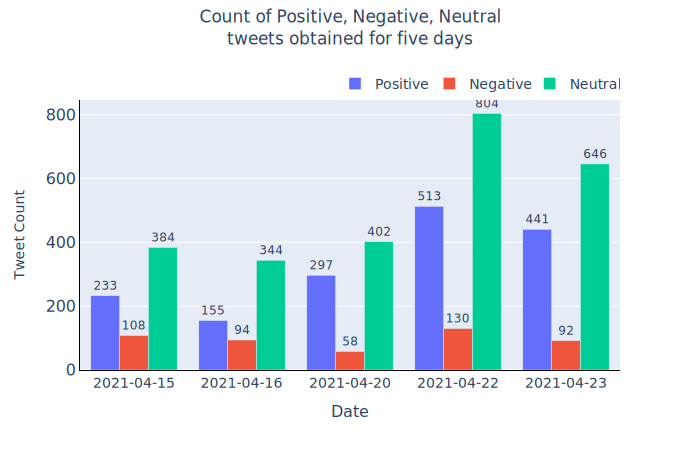

In [36]:
import pandas as pd

neg_count=plot2_dt[plot2_dt['predicted_sentiment']=='negative']['Clean_text'].values
pos_count=plot2_dt[plot2_dt['predicted_sentiment']=='positive']['Clean_text'].values
neu_count=plot2_dt[plot2_dt['predicted_sentiment']=='neutral']['Clean_text'].values

date_range=plot2_dt['date'].unique()
fig = go.Figure(data=[
    go.Bar(name='Positive', x=date_range, y=pos_count, text=pos_count),
    go.Bar(name='Negative', x=date_range, y=neg_count,text=neg_count),
    go.Bar(name='Neutral', x=date_range, y=neu_count,text=neu_count)
])
# Change the bar mode
fig.update_traces( textposition='outside')
fig.update_layout(title={'text': 'Count of Positive, Negative, Neutral <br>tweets obtained for five days',
                  'y':0.95,'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top'},
                  barmode='group',
                  #xaxis={},
                  yaxis_tickfont_size=16,
                  xaxis=dict(
                      title='Date',
                      titlefont_size=16,
                      tickfont_size=14,
                      type='category'),
                  legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.0,
                    xanchor="right",
                    x=1
                ),
                  legend_font_size=14
                  )
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(title='Tweet Count',showline=True, linewidth=1, linecolor='black')
fig.show()

## **Correlation between sentiment and stock price**


### For Nifty50

In [38]:
#Using stock data obtined from investing.com for identifying 
#correlation between stock price change and stock tweets sentiment 
stock_data=pd.read_csv('/content/^NSEI.csv',header=0)
stock_data['Date']=pd.to_datetime(stock_data['Date']).astype(str)
stock_data=stock_data.sort_values(by='Date')

In [39]:
req_stock_dt=stock_data[stock_data['Date'].isin(date_range)]
req_stock_dt

,Date,Price,Open,High,Low,Volume,Chg%
5,2021-04-15,"14,581.45","14,522.40","14,597.55","14,353.20",567.96M,0.53
4,2021-04-16,"14,617.85","14,599.60","14,697.70","14,559.00",577.23K,0.25
2,2021-04-20,"14,296.40","14,526.70","14,526.95","14,207.30",467.40K,-0.44
1,2021-04-22,"14,406.15","14,219.15","14,424.75","14,151.40",524.63K,0.77
0,2021-04-23,"14,341.35","14,326.35","14,461.15","14,273.30",498.06K,-0.45


In [40]:
#Calculating positive sentiment ratio for the 5 days data

precent_pos=pd.Series((pos_count[i]-neg_count[i])/(pos_count[i]+neg_count[i]) for i in range(0,5))

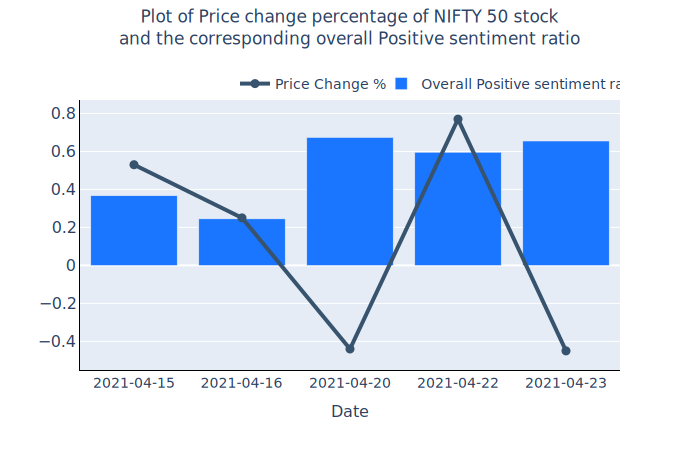

In [41]:
# plot the graph
fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Price Change %",
    line=dict( width=4),
    marker=dict(size=9),
    mode="markers+lines", x=date_range,y=req_stock_dt['Chg%'],
    marker_color='rgb(55, 83, 109)'
    
))
fig.add_trace(go.Bar(
    name="Overall Positive sentiment ratio",
    x=date_range, y=precent_pos,
    marker_color='rgb(26, 118, 255)',
    text=precent_pos,
))

fig.update_layout(title={
        'text': 'Plot of Price change percentage of NIFTY 50 stock <br>and the corresponding overall Positive sentiment ratio<br>',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
         barmode='group',
        yaxis_tickfont_size=16,
        xaxis=dict(
            type='category',
            title='Date',
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.0,
        xanchor="right",
        x=1
    ),
        legend_font_size=14
    )
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()

### For specific Company - Mahindra & Mahindra Limited

In [42]:
m_stock_data=pd.read_csv('/content/Mahindra_stock.csv',header=0)
m_stock_data['Date']=pd.to_datetime(m_stock_data['Date']).astype(str)
m_stock_data=m_stock_data.sort_values(by='Date')

req_stock_dt2=m_stock_data[stock_data['Date'].isin(date_range)]
req_stock_dt2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,Date,Price,Open,High,Low,Volume,Chg%
5,2021-04-15,174.40,175.10,179.50,168.50,10.01M,-1.47
4,2021-04-16,172.35,174.50,175.50,171.60,6.10M,-1.18
2,2021-04-20,170.90,168.00,175.90,167.85,12.54M,2.92
1,2021-04-22,175.45,168.25,176.75,166.95,13.22M,2.66
0,2021-04-23,179.20,176.25,181.25,171.80,21.74M,2.14


In [43]:
cp_plot2_dt = df1[['Clean_text','date','predicted_sentiment','Company']].groupby(['Company','predicted_sentiment','date']).count().reset_index()
cp_plot2_dt['Company'].unique()

array(['Bajaj Auto Limited', 'Bajaj Finserv Limited',
       'Mahindra & Mahindra Limited', 'Maruti Suzuki India Limited',
       'Nifty', 'Reliance Industries Limited', 'Tata Motors Limited'],
      dtype=object)

In [44]:
#extracting tweets associated with only Mahindra and Mahindra limited company
cp_plot2_dt=cp_plot2_dt[cp_plot2_dt['Company']=='Mahindra & Mahindra Limited']
cp_plot2_dt.head()

,Company,predicted_sentiment,date,Clean_text
16,Mahindra & Mahindra Limited,negative,2021-04-15,7
17,Mahindra & Mahindra Limited,negative,2021-04-16,4
18,Mahindra & Mahindra Limited,negative,2021-04-20,7
19,Mahindra & Mahindra Limited,negative,2021-04-22,27
20,Mahindra & Mahindra Limited,negative,2021-04-23,15


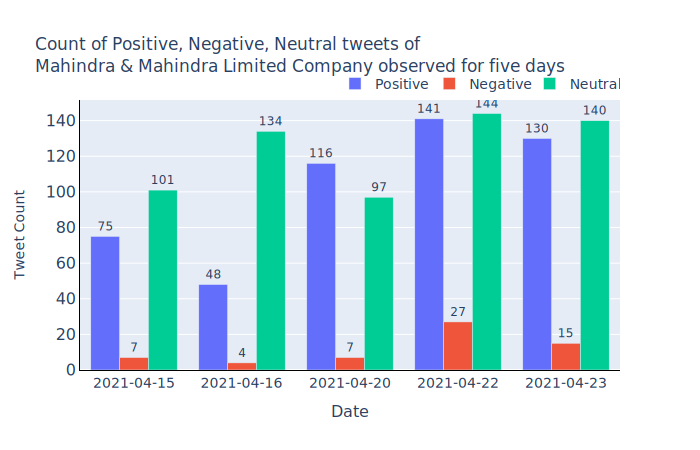

In [45]:
import pandas as pd
neg_count=[]
pos_count=[]
neu_count=[]
neg_count=cp_plot2_dt[cp_plot2_dt['predicted_sentiment']=='negative']['Clean_text'].values
pos_count=cp_plot2_dt[cp_plot2_dt['predicted_sentiment']=='positive']['Clean_text'].values
neu_count=cp_plot2_dt[cp_plot2_dt['predicted_sentiment']=='neutral']['Clean_text'].values

date_range=plot2_dt['date'].unique()

#plot the graph
fig = go.Figure(data=[
    go.Bar(name='Positive', x=date_range, y=pos_count, text=pos_count),
    go.Bar(name='Negative', x=date_range, y=neg_count,text=neg_count),
    go.Bar(name='Neutral', x=date_range, y=neu_count,text=neu_count)
])

fig.update_traces( textposition='outside')
fig.update_layout(title='Count of Positive, Negative, Neutral tweets of <br>Mahindra & Mahindra Limited Company observed for five days',
                  barmode='group',
                  yaxis_tickfont_size=16,

                  xaxis=dict(
                      type='category',
                      title='Date',
                      titlefont_size=16,
                      tickfont_size=14),
                  legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.0,
                    xanchor="right",
                    x=1
                ),
                  legend_font_size=14
                  )
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(title='Tweet Count',showline=True, linewidth=1, linecolor='black')
fig.show()

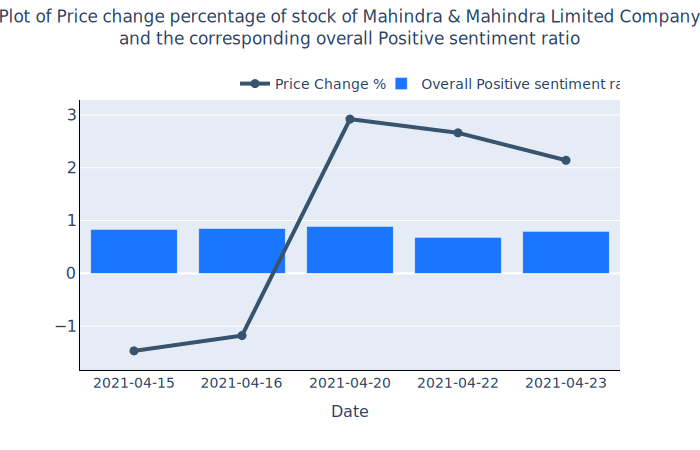

In [47]:
#calculating positive sentiment ratio for the Mahindra &Mahindra limited company tweets for 5 days

cp_precent_pos=pd.Series((pos_count[i]-neg_count[i])/(pos_count[i]+neg_count[i]) for i in range(0,5))

#fig = px.line(stock_data,x='Date', )
fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Price Change %",
    line=dict( width=4),
    marker=dict(size=9),
    mode="markers+lines", x=date_range,y=req_stock_dt2['Chg%'],
    marker_color='rgb(55, 83, 109)'
    
))
fig.add_trace(go.Bar(
    name="Overall Positive sentiment ratio",
    x=date_range,  y=cp_precent_pos,
    marker_color='rgb(26, 118, 255)',
    text=precent_pos,
))

fig.update_layout(title={
        'text': 'Plot of Price change percentage of stock of Mahindra & Mahindra Limited Company<br>and the corresponding overall Positive sentiment ratio<br>',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
         barmode='group',
        yaxis_tickfont_size=16,
        xaxis=dict(
            type='category',
            title='Date',
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.0,
        xanchor="right",
        x=1
    ),
        legend_font_size=14
    )
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()